In [21]:
import os
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.ticker as mticker
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [22]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'test'

In [23]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5', engine='h5netcdf') as ds:
    lev = ds['lev'].load()

results = {}
for model in MODELS:
    name = model['name']
    if 'kernel' not in name:
        continue
    filepath = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        if ('k1' in ds) and ('k2' in ds):
            k1,k2 = ds['k1'].load(),ds['k2'].load()
            k1mean,k2mean = k1.mean('seed'),k2.mean('seed')
            k1std,k2std   = k1.std('seed'),k2.std('seed')
            results[name] = dict(kind='mixture',mean1=k1mean,std1=k1std,mean2=k2mean,std2=k2std)
        else:
            k     = ds['k'].load()
            kmean = k.mean('seed')
            kstd  = k.std('seed')
            results[name] = dict(kind='single',mean=kmean,std=kstd)

print(f'Found {len(results)} kernel models with saved weights!')

Found 5 kernel models with saved weights!


In [24]:
families   = [('nonparametric','Nonparametric'),
              ('gaussian','Gaussian'),
              ('mixgaussian','Mixed Gaussian'),
              ('exponential','Exponential'),
              ('tophat','Top Hat')]
rowlabels   = ['RH',r'$\theta_e$',r'$\theta_e^*$']
nrows,ncols = 3,len(families)

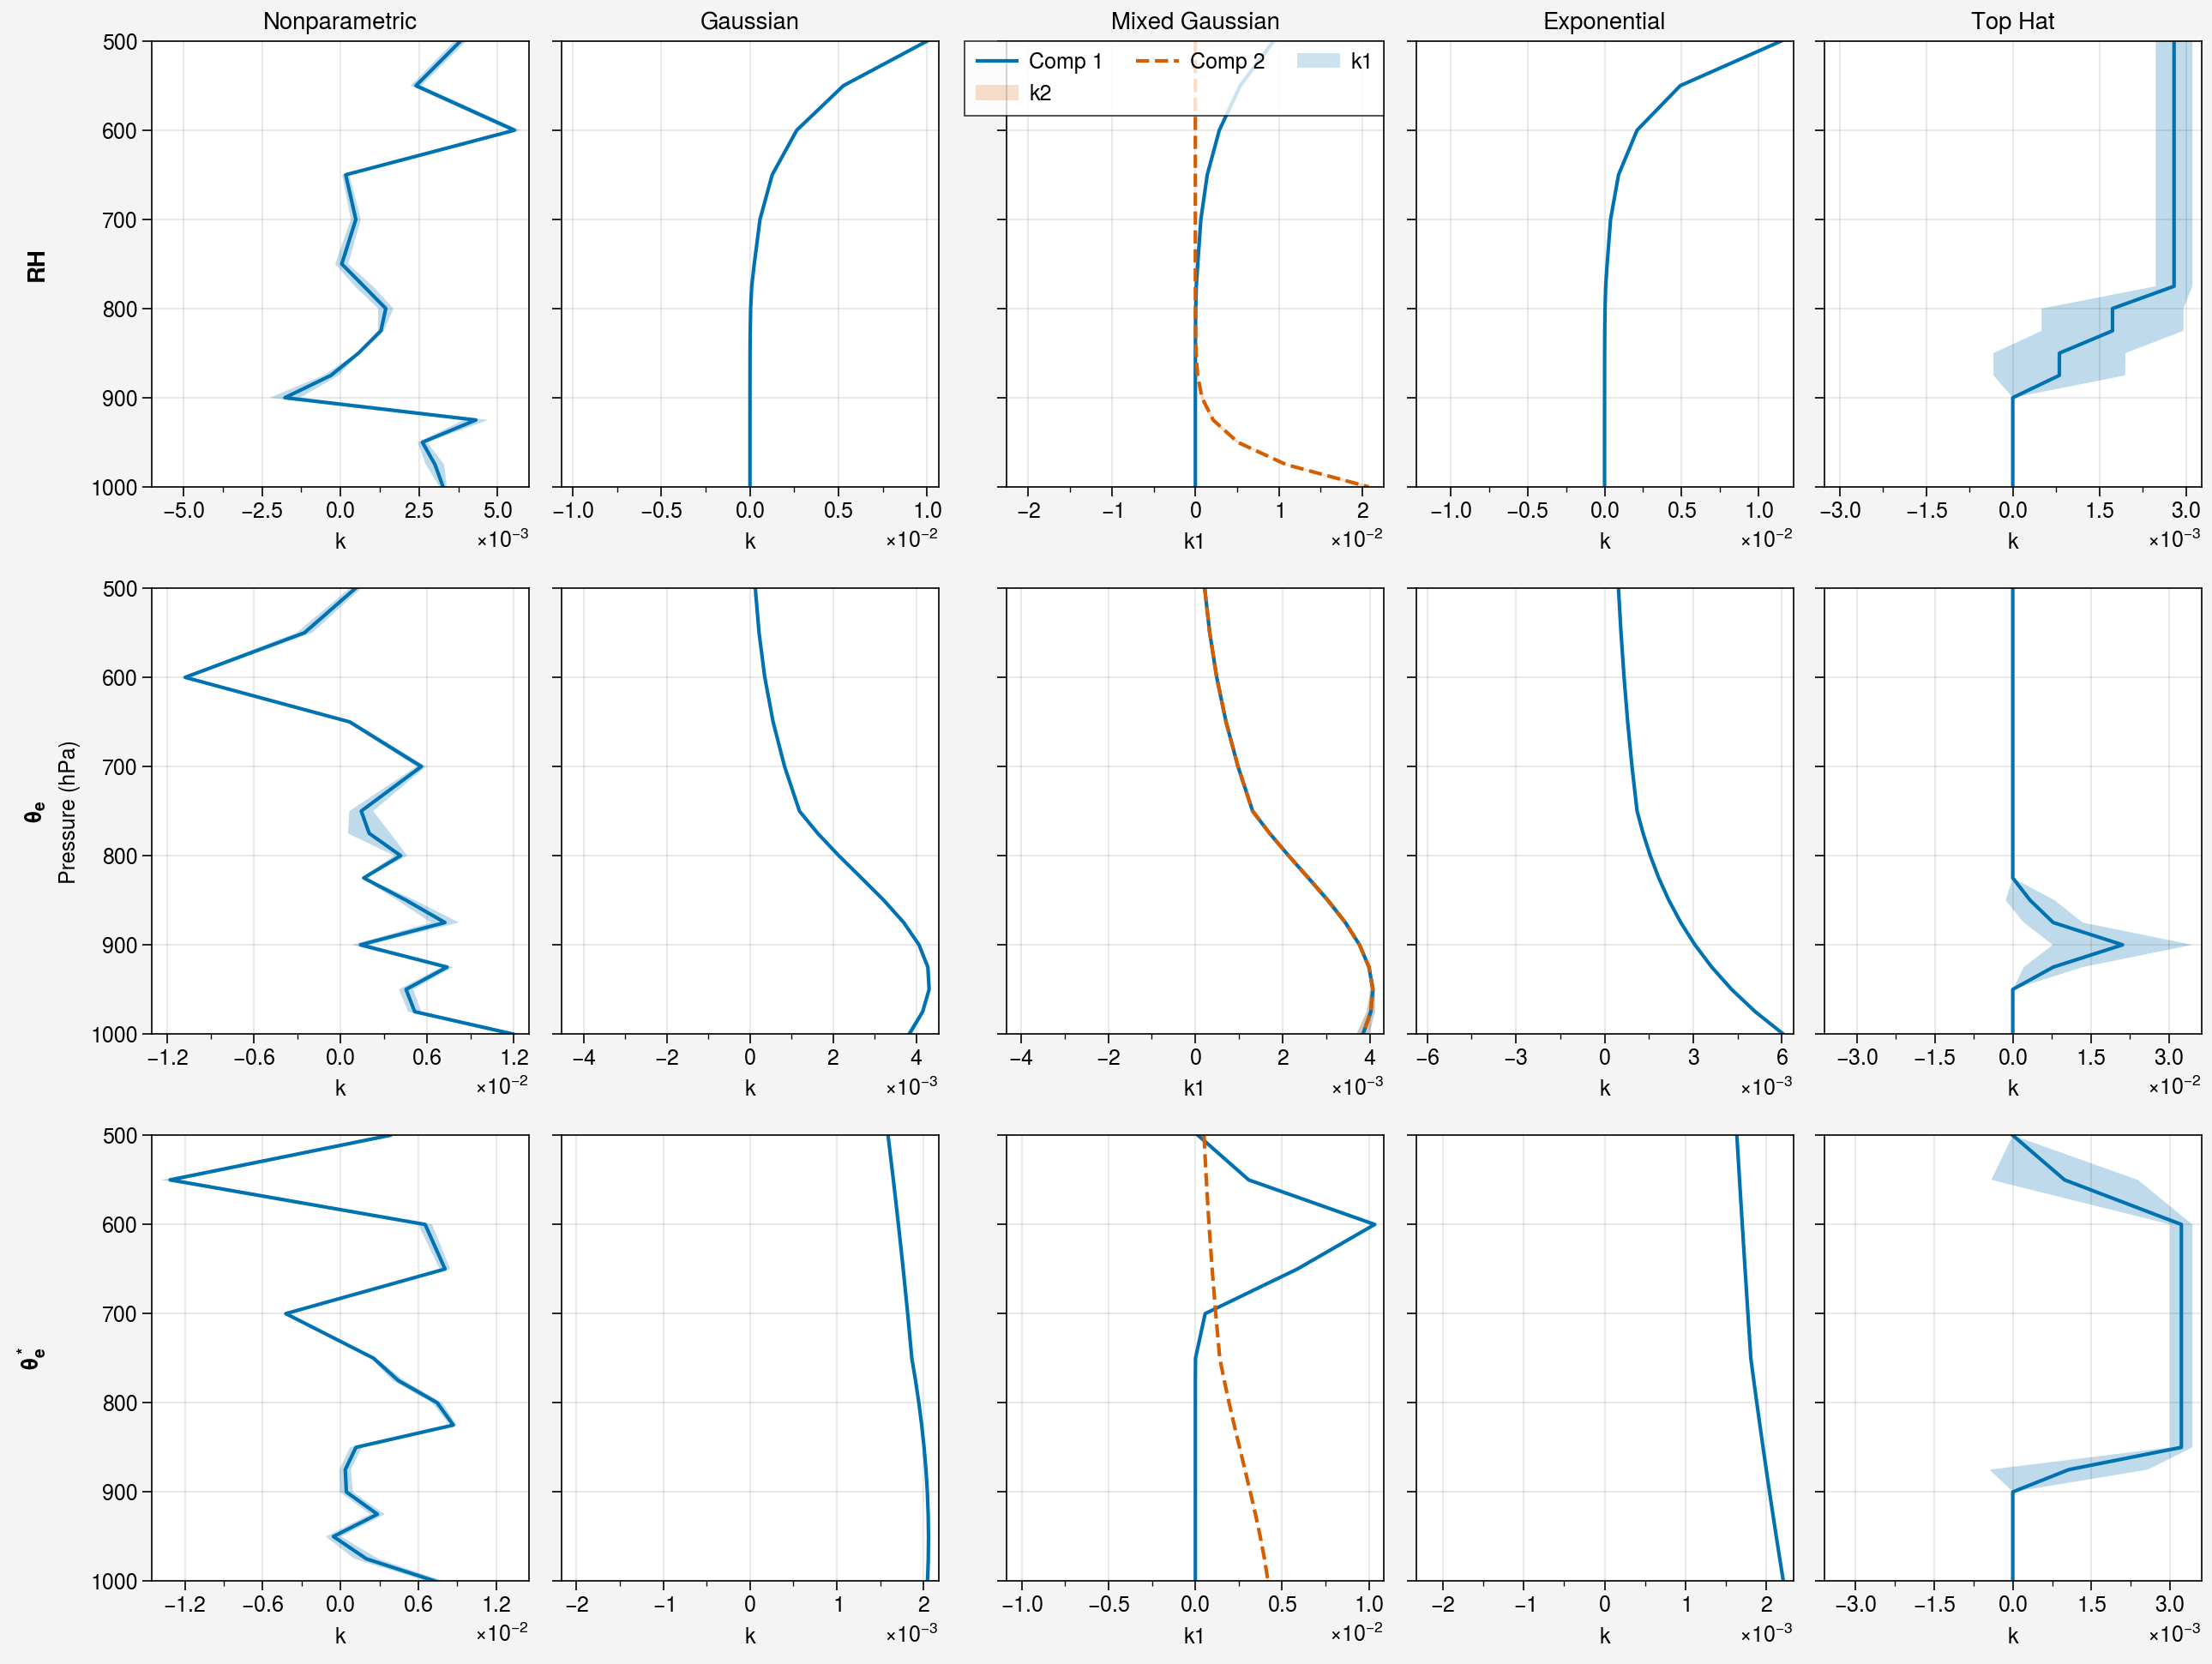

In [26]:
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2.2,refheight=2.6,sharey=True,sharex=False)
axs.format(yreverse=True,ylabel='Pressure (hPa)',yminorticks='none',rowlabels=rowlabels)

for j,(fam,title) in enumerate(families):
    axs[0,j].format(title=title)
    name = next((nm for nm in results if fam in nm), None)
    if name is None:
        for i in range(nrows):
            axs[i, j].format(alpha=0.35)
        continue
    entry = results[name]
    for i in range(nrows):
        ax = axs[i, j]
        if entry['kind'] == 'mixture':
            m1, s1 = entry['mean1'].isel(field=i), entry['std1'].isel(field=i)
            m2, s2 = entry['mean2'].isel(field=i), entry['std2'].isel(field=i)
            ax.plot(m1, lev, lw=1.5, label='Comp 1')
            ax.plot(m2, lev, lw=1.5, ls='--', label='Comp 2')
            ax.fill_betweenx(lev, m1-s1, m1+s1, alpha=0.2)
            ax.fill_betweenx(lev, m2-s2, m2+s2, alpha=0.2)
            if i == 0:
                ax.legend(loc='upper right', fontsize=7)
        else:
            m, s = entry['mean'].isel(field=i), entry['std'].isel(field=i)
            ax.plot(m, lev, lw=1.5)
            ax.fill_betweenx(lev, m-s, m+s, alpha=0.25)
        
        if entry['kind'] == 'mixture':
            vals = [m1.values, m2.values, (m1-s1).values, (m1+s1).values, (m2-s2).values, (m2+s2).values]
        else:
            vals = [m.values, (m-s).values, (m+s).values]
        maxabs = max(float(np.nanmax(np.abs(v))) for v in vals)
        maxabs = max(maxabs, 1e-12)
        ax.format(xlim=(-1.05*maxabs, 1.05*maxabs))  # 5% padding
    
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

pplt.show()
fig.save('../figs/weights.png')